# COMP0123 Complex Networks and Webs Coursework 1

Importing libraries

In [14]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from community import community_louvain
from collections import Counter

## Task 0 - Preparation of Network Data

### Creating our Author Network

- Among the millions of authors, firstly you extract all authors whose research interests are related to 'social network', including those with interests in 'Social network', 'social networks', 'human social network' etc.

In [2]:
# Creating our graph
G = nx.Graph()

In [3]:
# Retrieving indices of all author's who have an interest in 'social networks'
author_indices = []
interest = "social network"

with open("data/AMiner-Author.txt", 'r', encoding='utf-8') as f:
    current_author_index = 1
    for line in f:
        if line.startswith("#t"):
            interests = line[2:]
            # Check if any variant of the interest is in the author's interests.
            if interest in interests.lower():
                author_indices.append(current_author_index)
            current_author_index += 1

In [4]:
# Adding all author indices to the graph
G.clear()
G.add_nodes_from(author_indices)
G.number_of_nodes()

9219

- Secondly, you extract all links (co-authorships) among the above authors. You should discard any authors with degree 0 (that have no link with any of the other authors) and any repeated links, so that you create a simple graph.

In [5]:
# Adding in edges
edges = []
author_indices = set(author_indices)

with open("data/AMiner-Coauthor.txt", 'r') as f:
    for line in f:
        author1, author2, _ = line.split()
        author1 = int(author1[1:])
        author2 = int(author2)
        
        if (author1 in author_indices) and (author2 in author_indices):
            edges.append([author1, author2])
        

In [6]:
G.add_edges_from(edges)
G.number_of_edges()

12129

- Thirdly, you extract the giant component in the above simple graph. For your information, the giant component should contain 2,068 unique nodes and 5,163 unique links. Note that link a-b is same as link b-a, which is a single unique link, not two links.

In [7]:
# Achieving giant component
author_network = G.subgraph(max(nx.connected_components(G), key=len))

In [8]:
# Desired Values
n_count = 2068
e_count = 5163

In [9]:
# Achieving desired number of nodes
assert n_count == author_network.number_of_nodes()

In [10]:
# Achieving desired number of edges
assert e_count == author_network.number_of_edges()

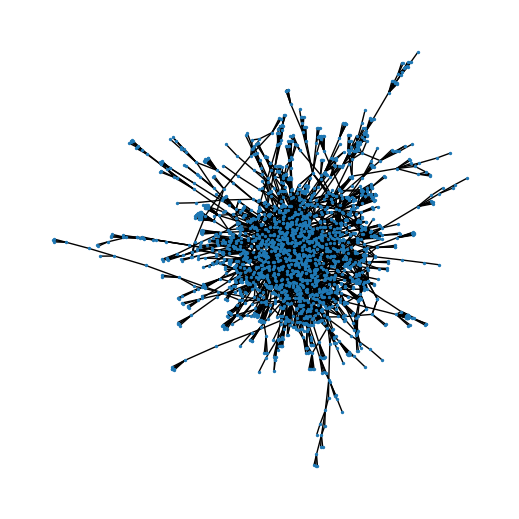

In [11]:
# Plotting Author Network
plt.figure(figsize=(5,5))
pos = nx.spring_layout(author_network, seed= 42)
nx.draw(author_network, node_size= 2, width= 1, pos= pos)

### Generating Random Network

We'll follow along with the Erdos-Renyi (ER) model: $G(N,M)$ Model

In [21]:
ER = nx.gnm_random_graph(n_count, e_count, seed= 42)

### Generating BA Network

$ E = m(N - N_{initial}) + E_{initial} $

$ 5163 = m(2068 - N_{initial}) + E_{initial} $


In [19]:
m = 3
n_initial = 520
e_initial = 519

In [20]:
# Creating our initial random graph
initial = nx.gnm_random_graph(n_initial, e_initial, seed= 42)
BA = nx.barabasi_albert_graph(n_count, m, initial_graph= initial, seed= 42)

## Task 1

- Calculate the average node degree and the maximum node degree of the 3 networks

$ \bar{k} \equiv \frac{1}{N} \sum^{N}_{i = 1} k_i = \frac{2E}{N}$

In [16]:
round(2 * e_count / n_count, 2)

4.99

In [17]:
"Author Network Max Degree: " + str(max(dict(author_network.degree()).values()))

'Author Network Max Degree: 51'

In [18]:
"Random Graph Max Degree: " + str(max(dict(ER.degree()).values()))

'Random Graph Max Degree: 13'

In [19]:
"BA Graph Max Degree: " + str(max(dict(BA.degree()).values()))

'BA Graph Max Degree: 48'

- Plot their degree distribution $P(k)$ on linear-linear scale and log-log scale,
respectively

$ P(k) = \frac{N_k}{N}$

In [20]:
def plot_degree_distribution_linear_scale(graphs, labels):
    colors = ["red", "green", "blue"]
    markers = ['o', 's', '^']

    plt.figure(figsize=(6,6))
    plt.title("Linear-Linear Scale")
    plt.xlabel("Degree k")
    plt.ylabel("Probability P(X = k)")
    
    for i, G in enumerate(graphs):
        N_k = nx.degree_histogram(G)[1:]
        pk = [i/sum(N_k) for i in N_k]  # normalized so they sum to 1
        k = list(range(1, len(N_k) + 1))
        plt.scatter(k, pk, c=colors[i], label=labels[i], marker= markers[i])
        # plt.plot(k, pk, c=color_map[i])  # this line connects the scatter points

    plt.legend(loc='upper right')
    plt.show()

def plot_degree_distribution_log_scale(graphs, labels):
    colors = ["red", "green", "blue"]
    markers = ['o', 's', '^']

    plt.figure(figsize=(6,6))
    plt.title("Log-Log Scale")
    plt.xlabel("Degree k")
    plt.ylabel("Probability P(X = k)")

    for i, G in enumerate(graphs):
        N_k = nx.degree_histogram(G)
        k = np.array(range(len(N_k)))
        pk = np.array([i/sum(N_k) for i in N_k])
        
        # Remove zero values to avoid log(0) errors
        mask = (k > 0) & (pk > 0)
        k = k[mask]
        pk = pk[mask]
        
        # Fit log-log data with a cubic polynomial
        log_k = np.log(k)
        log_pk = np.log(pk)
        coefficients = np.polyfit(log_k, log_pk, 3)
        poly = np.poly1d(coefficients)
        y_fit = np.exp(poly(np.log(k)))
        
        plt.loglog(k, pk, marker=markers[i], linestyle='none', color=colors[i], label=labels[i])
        plt.loglog(k, y_fit, color=colors[i])  # best fit curve
        
    plt.legend()
    plt.show()

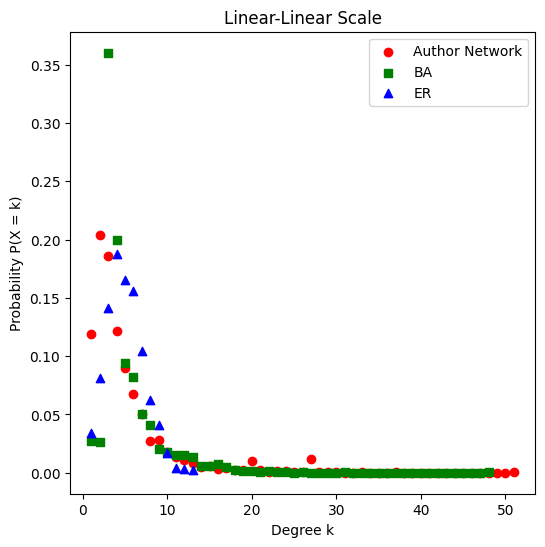

In [21]:
plot_degree_distribution_linear_scale([author_network, BA, ER], ['Author Network', 'BA', 'ER'])

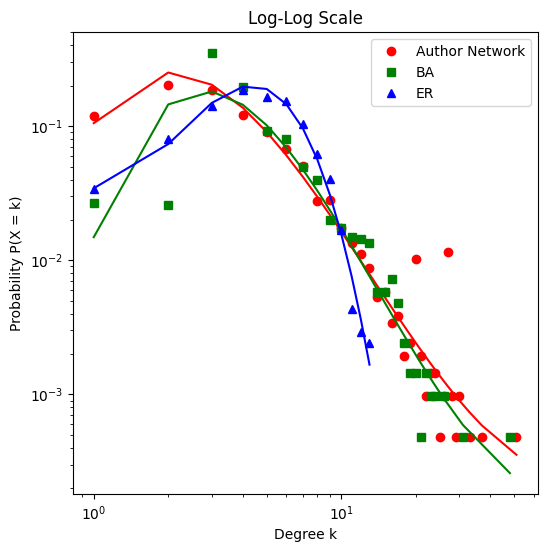

In [22]:
plot_degree_distribution_log_scale([author_network, BA, ER], ['Author Network', 'BA', 'ER'])

- Estimate the power-law exponent of the degree distribution P(k) of the author
network only.
  -  You can fit a curve by using the function polyfit from the numpy library.
  -  Ideally, you can do the fitting on CCDF (the complementary cumulative
distribution function) on log-log scale.

In [23]:
def compute_power_law_exponent(G):
    hist = np.array(nx.degree_histogram(G))
    degrees = np.arange(len(hist))

    # Remove zeros from the histogram to avoid issues with log transformation
    non_zero = hist > 0
    degrees = degrees[non_zero]
    hist = hist[non_zero]

    # Fit a line to the log-transformed data
    coefficients = np.polyfit(np.log(degrees[degrees > 0]), np.log(hist[degrees > 0]), 1)
    return -round(coefficients[0], 2)

print(f"Estimated power-law exponent (alpha): {compute_power_law_exponent(author_network)}")

Estimated power-law exponent (alpha): 2.01


## Task 2

- Calculate and plot the nearest neighbour’s average degree $knn$ as a function of
node degree $k$, on log-log scale.

In [24]:
def plot_knn(graphs, graph_names):
    colors = ["red", "green", "blue"]
    markers = ['o', 's', '^']
    
    plt.figure(figsize=(10,5))
    plt.title("Log-Log Scale")
    plt.xlabel("Node Degree k")
    plt.ylabel("Nearest Neighbour's Average Degree knn(k)")
    
    for i, G in enumerate(graphs):
        knn = nx.average_degree_connectivity(G)
        k = list(knn.keys())
        values = list(knn.values())

        # Sorting the k-values and corresponding knn-values
        sorted_pairs = sorted(zip(k, values))
        k_sorted, values_sorted = zip(*sorted_pairs)

        plt.loglog(k_sorted, values_sorted, linestyle='-', color=colors[i], marker=markers[i], label=graph_names[i])
    
    plt.legend()
    plt.show()

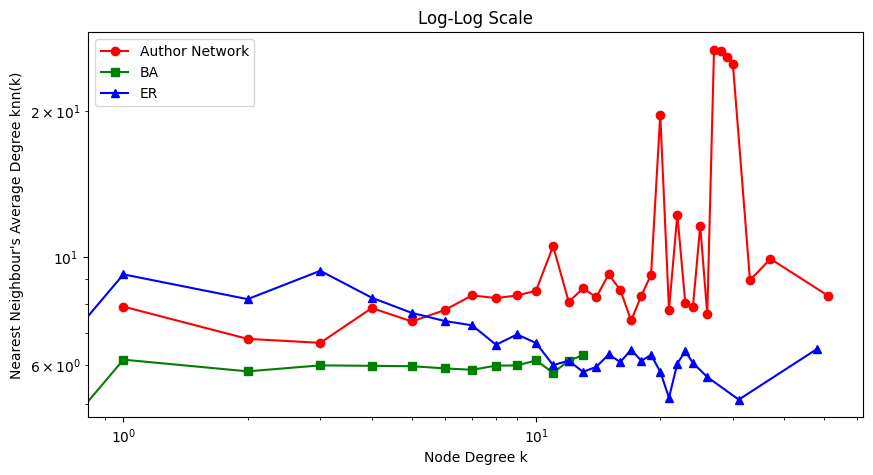

In [25]:
plot_knn([author_network, ER, BA], ['Author Network', 'BA', 'ER'])

- Calculate the assortative coefficient of the networks

In [26]:
print(f"Author Network Associative Coefficient: ", round(nx.degree_assortativity_coefficient(author_network), 2))

Author Network Associative Coefficient:  0.47


In [27]:
print(f"Random Network Associative Coefficient: ", round(nx.degree_assortativity_coefficient(ER), 2))

Random Network Associative Coefficient:  0.01


In [28]:
print(f"BA Network Associative Coefficient: ", round(nx.degree_assortativity_coefficient(BA), 2))

BA Network Associative Coefficient:  -0.16


## Task 3

- Calculate the diameter and the average shortest path length of the network.

In [29]:
# For computing disconnected graphs
def compute_avg_shortest_path_length(G):
    # Achieving giant component
    giant_component = G.subgraph(max(nx.connected_components(G), key=len))
    return nx.algorithms.average_shortest_path_length(giant_component)

def compute_diameter(G):
    giant_component = G.subgraph(max(nx.connected_components(G), key=len))
    return nx.diameter(giant_component)

In [30]:
print("Author Network")
print("Diameter: " + str(compute_diameter(author_network)))
print("Average Shortest Path Length: " + str(round(compute_avg_shortest_path_length(author_network), 2)))

Author Network
Diameter: 19
Average Shortest Path Length: 7.3


In [31]:
print("Random Network")
print("Diameter: " + str(compute_diameter(ER)))
print("Average Shortest Path Length: " + str(round(compute_avg_shortest_path_length(ER), 2)))

Random Network
Diameter: 10
Average Shortest Path Length: 4.93


In [32]:
print("BA Network")
print("Diameter: " + str(compute_diameter(BA)))
print("Average Shortest Path Length: " + str(round(compute_avg_shortest_path_length(BA), 2)))

BA Network
Diameter: 10
Average Shortest Path Length: 4.56


In [33]:
def average_betweenness_per_degree(G):
    # Calculate normalized betweenness centrality for all nodes
    betweenness = nx.betweenness_centrality(G, normalized=True)

    # Create a dictionary to hold sum of betweenness centrality and count for each degree k
    degree_dict = {}
    for node, k in G.degree():
        if k not in degree_dict:
            degree_dict[k] = {'sum': 0, 'count': 0}
        degree_dict[k]['sum'] += betweenness[node]
        degree_dict[k]['count'] += 1

    # Calculate average betweenness centrality for each degree k
    avg_betweenness = {k: v['sum'] / v['count'] for k, v in degree_dict.items()}

    return avg_betweenness

In [34]:
def plot_avg_betweenness(graphs, graph_names):
    colors = ["red", "green", "blue"]
    markers = ['o', 's', '^']
    
    plt.figure(figsize=(8,5))
    plt.title("Log-Log Average Node Betweenness of k-degree nodes")
    plt.xlabel("Degree (k)")
    plt.ylabel("Average Node Betweenness")
    
    for i, G in enumerate(graphs):
        avg_betweenness = average_betweenness_per_degree(G)
        
        # Sorting for coherent line plots
        sorted_pairs = sorted(avg_betweenness.items())
        degrees, betweenness_values = zip(*sorted_pairs)

        plt.loglog(degrees, betweenness_values, linestyle='-', color=colors[i], marker=markers[i], label=graph_names[i])
    
    plt.legend()
    plt.show()


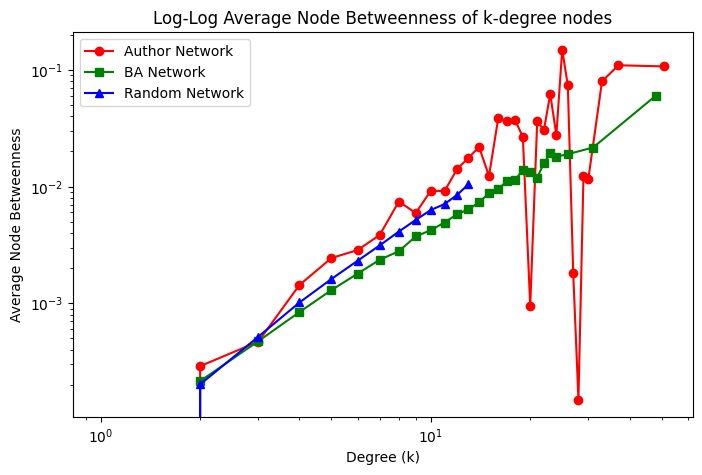

In [35]:
plot_avg_betweenness([author_network, BA, ER], ["Author Network", "BA Network", "Random Network"])

## Task 4

- Calculate and plot the rich-club coefficient as a function of node rank on log-log
scale.

In [36]:
def plot_rich_club(graphs, graph_names):
    colors = ["red", "green", "blue"]
    markers = ['o', 's', '^']

    plt.figure(figsize=(15,5))
    plt.subplot(121)

    for i, G in enumerate(graphs):
        # Calculate the rich-club coefficient
        rich_club = nx.rich_club_coefficient(G, normalized=False)

        sorted_degrees = sorted(rich_club.keys(), reverse=True)
        ranked_degrees = {k: i for i, k in enumerate(sorted_degrees, 1)}
        rich_club_ranks = {ranked_degrees[k]: rich_club[k] for k in sorted_degrees if rich_club[k] != 0}

        # By Node Rank
        plt.loglog(list(rich_club_ranks.keys()), list(rich_club_ranks.values()), 
                   color=colors[i], marker=markers[i], label=graph_names[i])

    plt.title('Log-Log Scale')
    plt.xlabel('Node Rank')
    plt.ylabel('Rich-Club Coefficient')
    plt.legend()
    plt.show()


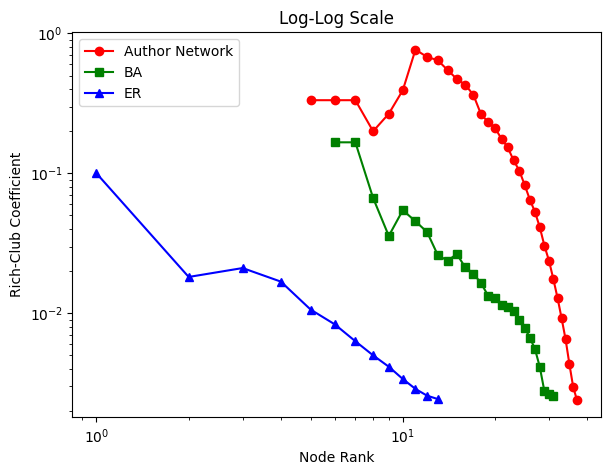

In [37]:
plot_rich_club([author_network, BA, ER], ['Author Network', 'BA', 'ER'])

- Calculate and plot the rich-club coefficient as a function of node degree on log-log scale

In [38]:
def plot_rich_club2(graphs, graph_names):
    colors = ["red", "green", "blue"]
    markers = ['o', 's', '^']

    plt.figure(figsize=(15,5))
    plt.subplot(122)

    for i, G in enumerate(graphs):
        # Calculate the rich-club coefficient
        rich_club = nx.rich_club_coefficient(G, normalized=False)

        # Sort by degree for plotting
        degrees = sorted(rich_club.keys())
        coefficients = [rich_club[degree] for degree in degrees]
        
        # By Node Degree
        plt.loglog(degrees, coefficients, color=colors[i], marker=markers[i], label=graph_names[i], linestyle='none')

    plt.title('Rich-Club Coefficient vs. Node Degree')
    plt.xlabel('Node Degree')
    plt.ylabel('Rich-Club Coefficient')
    plt.legend()
    plt.show()

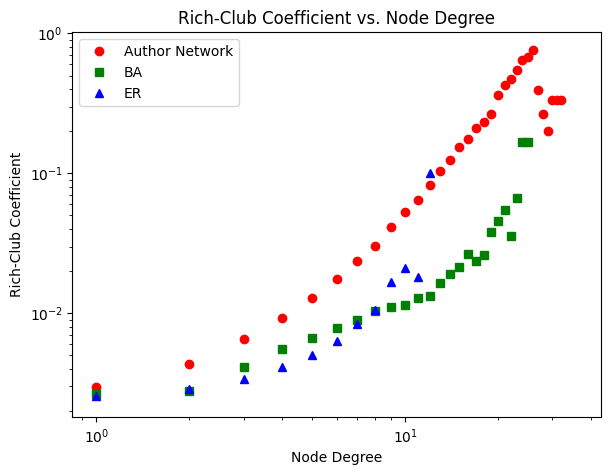

In [39]:
plot_rich_club2([author_network, BA, ER], ['Author Network', 'BA', 'ER'])

## Task 5

- Obtain the community structure (with the largest modularity value) of the 3
networks.

- Give the number of communities and the size (i.e. number of nodes) of the top 3
largest communities in each network

- Visualise the network and show each community with a different colour.

Author Network
Modularity Value: 0.9033077362656834
Number of Communites: 43
Largest Community Size: 132
2nd Largest Community Size: 120
3rd Largest Community Size: 119


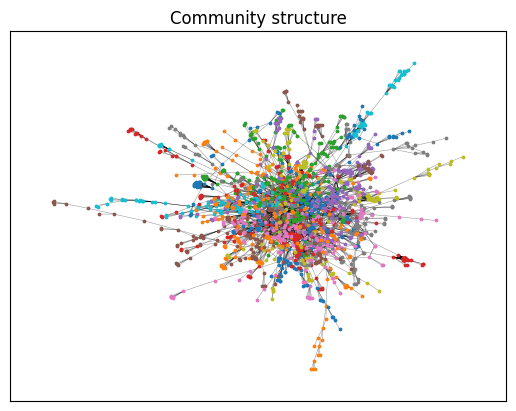

In [17]:
# Detect communities using the greedy modularity maximization
communities = nx.algorithms.community.louvain_communities(author_network, seed= 42)
communities = sorted(communities, key=lambda x: len(x), reverse=True)

# Calculate modularity
modularity_value = nx.community.modularity(author_network, communities)

# Community Information
print("Author Network")
print(f"Modularity Value: {round(modularity_value, 2)}")
print(f"Number of Communites: {len(communities)}")
print(f"Largest Community Size: {len(communities[0])}")
print(f"2nd Largest Community Size: {len(communities[1])}")
print(f"3rd Largest Community Size: {len(communities[2])}")

# Visualising Communities
pos = nx.spring_layout(author_network, seed= 42)

for i, community in enumerate(communities):
    nx.draw_networkx_nodes(author_network, pos, community, node_size=3, node_color=f"C{i}")
nx.draw_networkx_edges(author_network, pos, alpha=0.5, width= 0.3)
plt.title(f"Community structure")
plt.show()


Random Network
Modularity Value: 0.4428302832221205
Number of Communites: 31
Largest Community Size: 151
2nd Largest Community Size: 142
3rd Largest Community Size: 131


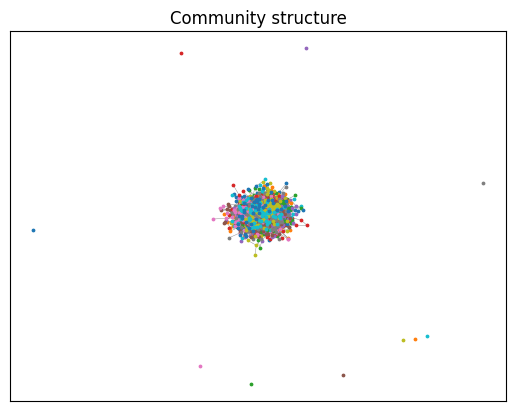

In [23]:
# Detect communities using the greedy modularity maximization
communities = nx.algorithms.community.louvain_communities(ER, seed= 42)
communities = sorted(communities, key=lambda x: len(x), reverse=True)

# Calculate modularity
modularity_value = nx.community.modularity(ER, communities)

# Community Information
print("Random Network")
print(f"Modularity Value: {round(modularity_value, 2)}")
print(f"Number of Communites: {len(communities)}")
print(f"Largest Community Size: {len(communities[0])}")
print(f"2nd Largest Community Size: {len(communities[1])}")
print(f"3rd Largest Community Size: {len(communities[2])}")

# Visualising Communities
pos = nx.spring_layout(ER, seed= 42)

for i, community in enumerate(communities):
    nx.draw_networkx_nodes(ER, pos, community, node_size=3, node_color=f"C{i}")
nx.draw_networkx_edges(ER, pos, alpha=0.5, width= 0.3)
plt.title(f"Community structure")
plt.show()

BA Network
Modularity Value: 0.44
Number of Communites: 79
Largest Community Size: 167
2nd Largest Community Size: 152
3rd Largest Community Size: 151


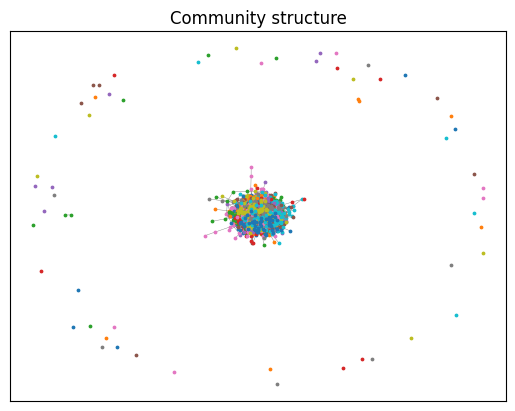

In [42]:
# Detect communities using the greedy modularity maximization
communities = nx.algorithms.community.louvain_communities(BA, seed= 42)
communities = sorted(communities, key=lambda x: len(x), reverse=True)

# Calculate modularity
modularity_value = nx.community.modularity(BA, communities)

# Community Information
print("BA Network")
print(f"Modularity Value: {round(modularity_value, 2)}")
print(f"Number of Communites: {len(communities)}")
print(f"Largest Community Size: {len(communities[0])}")
print(f"2nd Largest Community Size: {len(communities[1])}")
print(f"3rd Largest Community Size: {len(communities[2])}")

# Visualising Communities
pos = nx.spring_layout(BA, seed= 42)

for i, community in enumerate(communities):
    nx.draw_networkx_nodes(BA, pos, community, node_size=3, node_color=f"C{i}")
nx.draw_networkx_edges(BA, pos, alpha=0.5, width= 0.3)
plt.title(f"Community structure")
plt.show()

## Task 6

- Randomly rewire the 3 networks while preserving the degree distribution; and 
obtain the maximal random case of each network.

*Structural constraints in complex networks Section 2.1 (Maximal Random Case 1)* randomly choose a pair of links and swap two of their end nodes. This is equivalent to reconnecting the four end nodes using a wiring pattern chosen at random. The process is repeated a sufficiently large number of times.

In [43]:
def rewire(G):
    G_rewired = nx.Graph.copy(G)
    nx.algorithms.double_edge_swap(G_rewired, nswap= e_count, max_tries= e_count * 10, seed= 42)
    return G_rewired

In [44]:
author_network_rewired = rewire(author_network)
ER_rewired = rewire(ER)
BA_rewired = rewire(BA)

- For the 3 randomised networks, plot their degree distribution

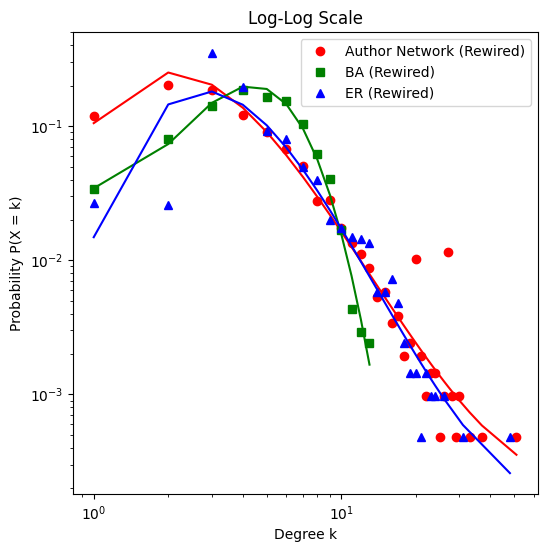

In [45]:
plot_degree_distribution_log_scale([author_network_rewired, ER_rewired, BA_rewired], ['Author Network (Rewired)', 'BA (Rewired)', 'ER (Rewired)'])

- Calculate the average clustering coefficient, the assortative coefficient, and the average shortest path length of the 3 networks and the 3 randomised networks; show and compare the results in a table. 

In [46]:
print(f"Author Network Avg Clustering Coefficient: {round(nx.algorithms.average_clustering(author_network), 2)}")
print(f"Author Network (Rewired) Avg Clustering Coefficient: {round(nx.algorithms.average_clustering(author_network_rewired), 2)}")
print(f"Author Network Assortative Coefficient: {round(nx.algorithms.degree_assortativity_coefficient(author_network), 2)}")
print(f"Author Network (Rewired) Assortative Coefficient: {round(nx.algorithms.degree_assortativity_coefficient(author_network_rewired), 2)}")
print(f"Author Network Avg Shortest Path Length: {round(compute_avg_shortest_path_length(author_network), 2)}")
print(f"Author Network (Rewired) Avg Shortest Path Length: {round(compute_avg_shortest_path_length(author_network_rewired), 2)}")

Author Network Avg Clustering Coefficient: 0.62
Author Network (Rewired) Avg Clustering Coefficient: 0.01
Author Network Assortative Coefficient: 0.47
Author Network (Rewired) Assortative Coefficient: 0.05
Author Network Avg Shortest Path Length: 7.3
Author Network (Rewired) Avg Shortest Path Length: 4.43


In [47]:
print(f"Random Network Avg Clustering Coefficient: {round(nx.algorithms.average_clustering(ER), 2)}")
print(f"Random Network (Rewired) Avg Clustering Coefficient: {round(nx.algorithms.average_clustering(ER_rewired), 2)}")
print(f"Random Network Assortative Coefficient: {round(nx.algorithms.degree_assortativity_coefficient(ER), 2)}")
print(f"Random Network (Rewired) Assortative Coefficient: {round(nx.algorithms.degree_assortativity_coefficient(ER_rewired), 2)}")
print(f"Random Network Avg Shortest Path Length: {round(compute_avg_shortest_path_length(ER), 2)}")
print(f"Random Network (Rewired) Avg Shortest Path Length: {round(compute_avg_shortest_path_length(ER_rewired), 2)}")

Random Network Avg Clustering Coefficient: 0.0
Random Network (Rewired) Avg Clustering Coefficient: 0.0
Random Network Assortative Coefficient: 0.01
Random Network (Rewired) Assortative Coefficient: -0.03
Random Network Avg Shortest Path Length: 4.93
Random Network (Rewired) Avg Shortest Path Length: 4.94


In [48]:
print(f"BA Network Avg Clustering Coefficient: {round(nx.algorithms.average_clustering(BA), 2)}")
print(f"BA Network (Rewired) Avg Clustering Coefficient: {round(nx.algorithms.average_clustering(BA_rewired), 2)}")
print(f"BA Network Assortative Coefficient: {round(nx.algorithms.degree_assortativity_coefficient(BA), 2)}")
print(f"BA Network (Rewired) Assortative Coefficient: {round(nx.algorithms.degree_assortativity_coefficient(BA_rewired), 2)}")
print(f"BA Network Avg Shortest Path Length: {round(compute_avg_shortest_path_length(BA), 2)}")
print(f"BA Network (Rewired) Avg Shortest Path Length: {round(compute_avg_shortest_path_length(BA_rewired), 2)}")

BA Network Avg Clustering Coefficient: 0.01
BA Network (Rewired) Avg Clustering Coefficient: 0.0
BA Network Assortative Coefficient: -0.16
BA Network (Rewired) Assortative Coefficient: -0.03
BA Network Avg Shortest Path Length: 4.56
BA Network (Rewired) Avg Shortest Path Length: 4.55
